In [39]:
%pip install -e ../introdl

Obtaining file:///Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff%40gmail.com/My%20Drive/Python_Projects/DS776_Develop_Project/DS776/introdl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for introdl (pyproject.toml) ... done
  Created wheel for introdl: filename=introdl-1.0-0.editable-py3-none-any.whl size=1371 sha256=6c843bc7020326b756c1c83186914f2be43d138cab3a5b74edfff853dc4b2c82
  Stored in directory: /private/var/folders/8w/0_6f1mnj291b3dfy5xqyp1rd3h18sr/T/pip-ephem-wheel-cache-xsa5m3ni/wheels/5b/bf/70/55a8428f6f3d659e30893470f0f3288d50ebdacbeb3fda3f35
Successfully built introdl
    torch (>=1.9.*)
           ~~~~~~^
  Attempting uninstall: introdl
    Found existing installation: introdl 1.0
    Uninstalling introdl-1.0:
      Successfully uninstalled introdl-1.0
Note: you may need to rest

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR

from introdl.utils import get_device, load_results, create_CIFAR10_loaders
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.metrics import accuracy_score

data_dir = '../../data'

## Learning Rate Schedulers

Another method for enhancing training is to use a learning rate scheduler.  A scheduler varies the learning rate, usually changing it once per epoch, in way to try to improve convergence.  Lowering the learning rate can be beneficial when training slows down and we want to squeeze a little more out of the training process.  Raising the learning rate can encourage the training process to explore new regions of the parameter space in hopes of finding better minima.  While several different learning rate schedulers were discussed in the text we'll describe two more here that are widely used in practice: OneCycleLR and CosineAnnealingWarmRestarts.  For each of these we'll give a brief description, then we'll demonstrate both with AdamW for training our SimpleCNN model on CIFAR-10.

### OneCycleLR

The OneCycleLR scheduler in PyTorch implements the *1cycle* policy [developed by Leslie Smith](https://arxiv.org/abs/1803.09820), which adjusts the learning rate and momentum in a cyclical manner during training. This scheduler is designed to help models converge faster and potentially achieve better performance. The learning rate starts at a low value, increases to a maximum, and then decreases back to a low value. Simultaneously, the momentum varies inversely with the learning rate.  It has [many adjustable parameters](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html), but often the default parameters work well.  You'll need to specify at least three parameters:
* `max_lr`: the peak learning rate during the cycle
* `epochs`: the number of epochs for training
* `steps_per_epoch`: number of batches in one epoch

#### Why it works

The 1cycle policy is based on the idea that increasing the learning rate can help the optimizer jump out of local minima, and decreasing it allows for fine-tuning around the global minimum. By starting with a low learning rate, the model begins training cautiously. Increasing the learning rate encourages exploration of the parameter space, potentially escaping shallow local minima. Decreasing the learning rate towards the end allows the model to settle into a deeper minimum. The cyclical adjustment of momentum inversely to the learning rate helps in smoothing the optimization process.

This scheduler is the basis for the `fit_one_cycle` method in the **fastai** library, which has been widely adopted due to its effectiveness in training deep learning models efficiently and achieving better generalization.

The code below uses PyTorch to simulate the learning rate over 20 epochs and visualize the learning rate patterns.  Each 'step' of the scheduler replaces the learning rate in the optimizer its connected to.  You can modify this code to graph other learning rate schedules if desired.

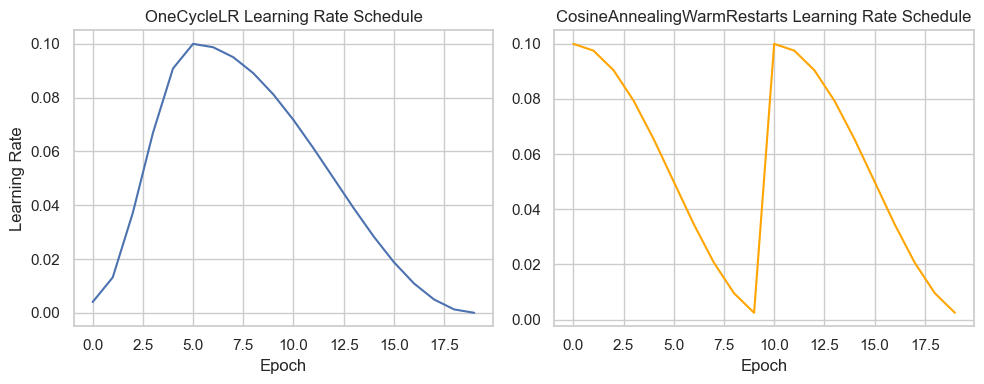

In [7]:
# Simulate a dummy model and optimizer
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)

# Set parameters
epochs = 20
steps_per_epoch = 1  # We assume one step per epoch for simplicity
max_lr = 0.1

# Lists to store learning rates
lrs_onecycle = []
lrs_cosine = []

# Define OneCycleLR scheduler
scheduler_onecycle = OneCycleLR(optimizer, max_lr=max_lr, total_steps=epochs * steps_per_epoch)

# Collect learning rates for OneCycleLR
for epoch in range(epochs):
    lrs_onecycle.append(optimizer.param_groups[0]['lr'])
    scheduler_onecycle.step()  # Step the scheduler

# Reset optimizer and use CosineAnnealingWarmRestarts
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)

# Define CosineAnnealingWarmRestarts scheduler
scheduler_cosine = CosineAnnealingWarmRestarts(optimizer, T_0=10)

# Collect learning rates for CosineAnnealingWarmRestarts
for epoch in range(epochs):
    lrs_cosine.append(optimizer.param_groups[0]['lr'])
    scheduler_cosine.step()  # Step the scheduler

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(range(epochs), lrs_onecycle, label="OneCycleLR")
ax1.set_title("OneCycleLR Learning Rate Schedule")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate")

ax2.plot(range(epochs), lrs_cosine, label="CosineAnnealingWarmRestarts", color='orange')
ax2.set_title("CosineAnnealingWarmRestarts Learning Rate Schedule")
ax2.set_xlabel("Epoch")

plt.tight_layout()
plt.show()



### CosineAnnealingWarmRestarts

The CosineAnnealingWarmRestarts scheduler periodically reduces and resets the learning rate in a cosine decay pattern. This approach mimics the concept of restarts in simulated annealing, enabling the optimizer to escape local minima by reintroducing higher learning rates periodically. The cyclic decay often leads to improved generalization by allowing the model to explore diverse regions of the loss landscape. The parameters you'll need to set are:
- **T_0**: Number of iterations in the first cycle, which sets the initial cycle length.
- **T_mult**: Factor by which the cycle length is multiplied after each restart, allowing cycles to gradually grow longer.  The default is 1 and is usually fine.
- **eta_min**: Minimum learning rate at the end of the cycle.  The default of 0 is usually fine.

### Why It Works:
The cosine decay provides smooth learning rate reductions, and the periodic resets prevent premature convergence, giving the optimizer more flexibility. This is especially useful for complex tasks where escaping local minima can improve performance.  Particularly computer vision and NLP tasks with complex models and widely varying datasets.  It's not as useful for simple models and tasks.


## Schedulers with CIFAR-10

Here we'll demonstrate the use of these schedulers for training SimpleCNN with AdamW.  The next cell is just a copy of the code for our model and for our CIFAR-10 DataLoaders.

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

train_loader, valid_loader, test_loader = create_CIFAR10_loaders(data_dir=data_dir, use_augmentation=True)

Files already downloaded and verified
Files already downloaded and verified


### OneCycleLR

For OneCycleLR it's typical to update the learning rate after every batch.  To do that we'll use `len(train_loader)` to determine how many batches are in the DataLoader and use that value for `steps_per_epoch`.  Since we've been using lr = 0.001 or even smaller with AdamW we'll try a peak learning rate of 0.01 by setting `max_lr = 0.01`.  20 epochs is typical for our other training runs so we'll try it here as well.  We also need to let our trainer know to update the learning rate after each batch by setting `scheduler_step_per_batch=True.`

In [16]:
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)

epochs = 20
max_lr = 0.01
scheduler = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

device = get_device()
print(device)

ckpt_file = 'models/model_CIFAR10_AdamW_one_cycle.pt'

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file,
    lr_schedule = scheduler,
    scheduler_step_per_batch=True);

mps


Epoch: 100%|██████████| 20/20 [09:03<00:00, 27.16s/it]


Let's have a look at the performance metrics:

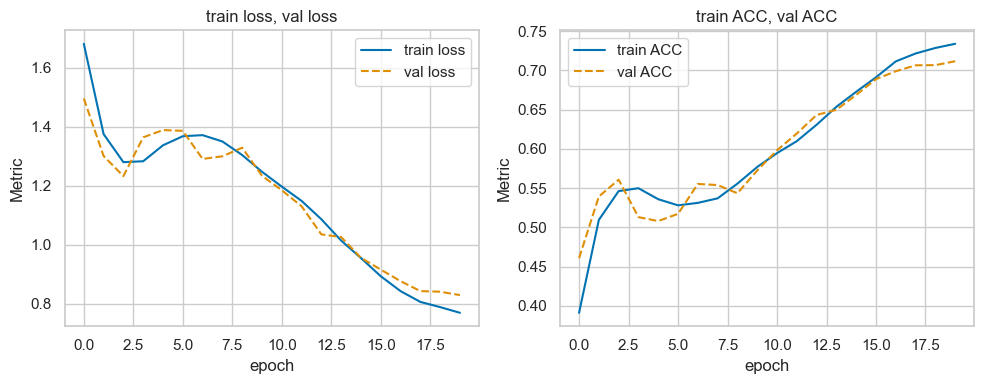

In [17]:
ckpt_file = 'models/model_CIFAR10_AdamW_one_cycle.pt'
results = load_results(ckpt_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])



We can also plot the learning rate saved at the end of each epoch (available whenever you use a scheduler):

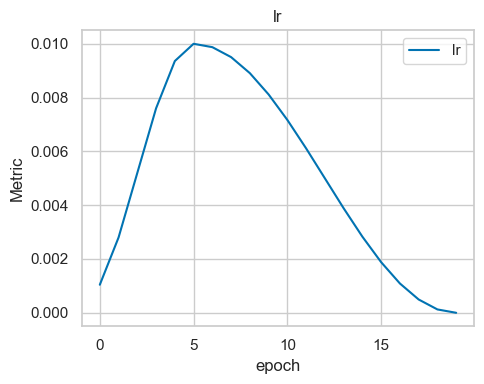

In [18]:
plot_training_metrics(results, [['lr']])

We can compare that performance to that of our baseline AdamW training:

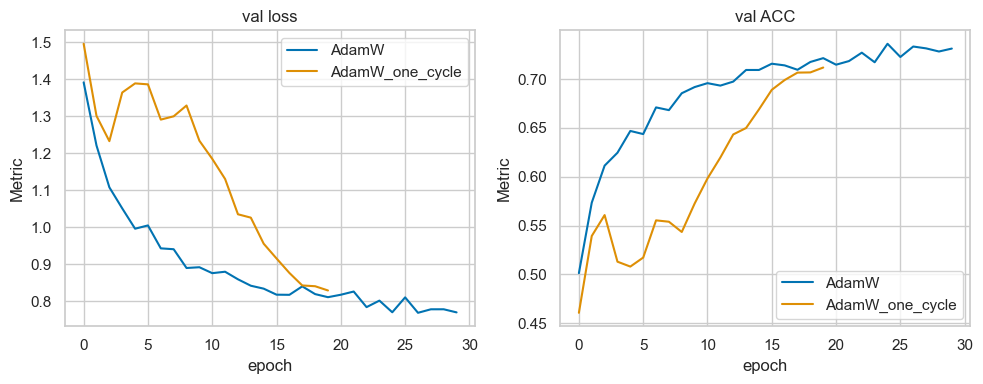

In [19]:
ckpt_file = 'models/model_CIFAR10_AdamW_augment.pt'
results_AdamW = load_results(ckpt_file)

ckpt_file = 'models/model_CIFAR10_AdamW_one_cycle.pt'
results_AdamW_1cycle = load_results(ckpt_file)

plot_training_metrics([results_AdamW, results_AdamW_1cycle], [['val loss'], ['val ACC']],df_labels=['AdamW', 'AdamW_one_cycle'])


### CosineAnnealingWarmRestarts

Below, we'll implement the CosineAnnealingWarmRestarts scheduler to see if it improves or accelerates the training of our CNN using AdamW.  We'll continue to use the same data augmentation strategy.  

For set up we've copied the model, data loaders function, and augmentation transforms from the augmentation notebook:

Since we've been successfully training our model on CIFAR-10 in around 20 to 30 epochs we decided to use a period of 10 for the cosine decay so we'd get in at least a few cycles to see if that improves the training.

In [20]:
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10*len(train_loader), T_mult=1, eta_min=0.0001)

device = get_device()
print(device)

ckpt_file = 'models/model_CIFAR10_AdamW_scheduler.pt'
epochs = 30

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file,
    lr_schedule = scheduler,
    scheduler_step_per_batch=True);

mps


Epoch: 100%|██████████| 30/30 [13:38<00:00, 27.30s/it]


The overfitting is again mild but notice that the accuracy on the validation set increases to about 75% instead of the approximately 73% we saw previously without using a scheduler.

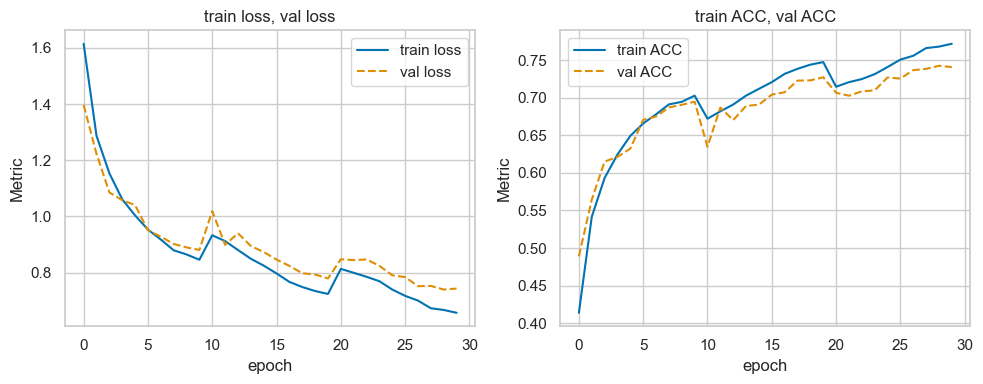

In [21]:
ckpt_file = 'models/model_CIFAR10_AdamW_scheduler.pt'
results = load_results(ckpt_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

Below, we'll plot the the metrics on the validation data using AdamW and augmentation with and without the learning rate scheduler.  We can see that the use of the cosine learning rate scheduler results in slightly improved performance.

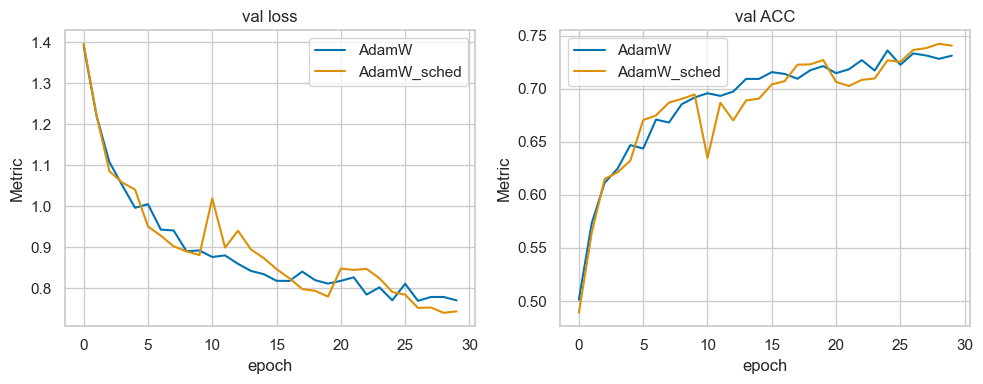

In [22]:
ckpt_file = 'models/model_CIFAR10_AdamW_augment.pt'
results_AdamW = load_results(ckpt_file)

ckpt_file = 'models/model_CIFAR10_AdamW_scheduler.pt'
results_AdamW_sched = load_results(ckpt_file)

plot_training_metrics([results_AdamW, results_AdamW_sched], [['val loss'], ['val ACC']],df_labels=['AdamW', 'AdamW_sched'])

Both of the schedulers we explored above for helping to train SimpleCNN with AdamW didn't do much, if anything, to increase performance.  This is likely because AdamW does such a great job adapting the learning rates that there isn't much room for improvement.  

In the next lesson we'll see that by enhancing our models with new layers and structures we can build deeper, complexer models whose training will benefit tremendously from using learning rate schedulers.  Stay tuned!

### Choosing a scheduler in practice

For small datasets and/or simple models using AdamW without a scheduler is probably fine.  OneCycleLR is often effective for aggressive training of complex models with AdamW.  If you're not sure what to do, then start by surveying the literature for papers related to your problem and run experiments based on what you found.  You can always randomly sample a smaller training set and perhaps pick a simpler version of your model to see what works before scaling up.